In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import random
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import exists, expanduser

from src.skeleton_morphology import run_morphology_analysis, strahler_order
from src.connectome import Connectome
from src.utils import load_preprocessed_connectome, yymmdd_today
from src.node_ops import segment_skeleton, find_end_points, find_central_segment, measure_path_lengths, measure_seg_distances
from vis.fig_tools import subtype_cm

plt.rcdefaults()
plt.style.use('vis/lamina.mplstyle')

In [8]:
tp = '200507'
C = load_preprocessed_connectome(f"~/Data/{tp}_lamina/")

Pickle loaded from: /mnt/home/nchua/Data/200507_lamina/200507_preprocessed.pickle


In [9]:
results_file = expanduser(f'~/Data/{tp}_lamina/{yymmdd_today()}_lmc-morphology.json')
subtypes = ['LMC_1', 'LMC_2', 'LMC_3', 'LMC_4', 'LMC_N']#, 'LMC_3', 'LMC_4']#, 'LMC_N']#, 'R7', 'R8', 'R7p']
these_skels = [s for s, data in C.skel_data.items() if data.subtype in subtypes]

if exists(results_file):
    with open(results_file, 'r') as fh:
        d = json.load(fh)
        segments, central_segs, seg_lens, seg_dists, strahler = d['segments'], d['central_segs'], d['seg_lengths'], d['seg_distances'], d['strahler']
else:
    segments, central_segs, seg_lens, seg_dists, strahler = run_morphology_analysis(C, 
                                                                                    these_skels, 
                                                                                    restrict_tags='lamina_end', 
                                                                                    save_file=results_file, 
                                                                                    verbose=False)

segments, central_segs, seg_lens, seg_dists, strahler = d['segments'], d['central_segs'], d['seg_lengths'], d['seg_distances'], d['strahler']

In [ ]:
summary_data = []
for skel_id in these_skels:
    data = C.skel_data[skel_id]
    summary_data.append({'name': data.name,
                         'skel_id': data.skel_id,
                         'om': data.group,
                         'subtype': data.subtype,
                         'n_central_nodes': len(central_segs[skel_id]), 
                         'n_nodes': len(data.skel_nodes) - len(data.r_nodes), 
                         'n_segments': len(segments[skel_id])})
summary_data = pd.DataFrame(summary_data).set_index('skel_id')

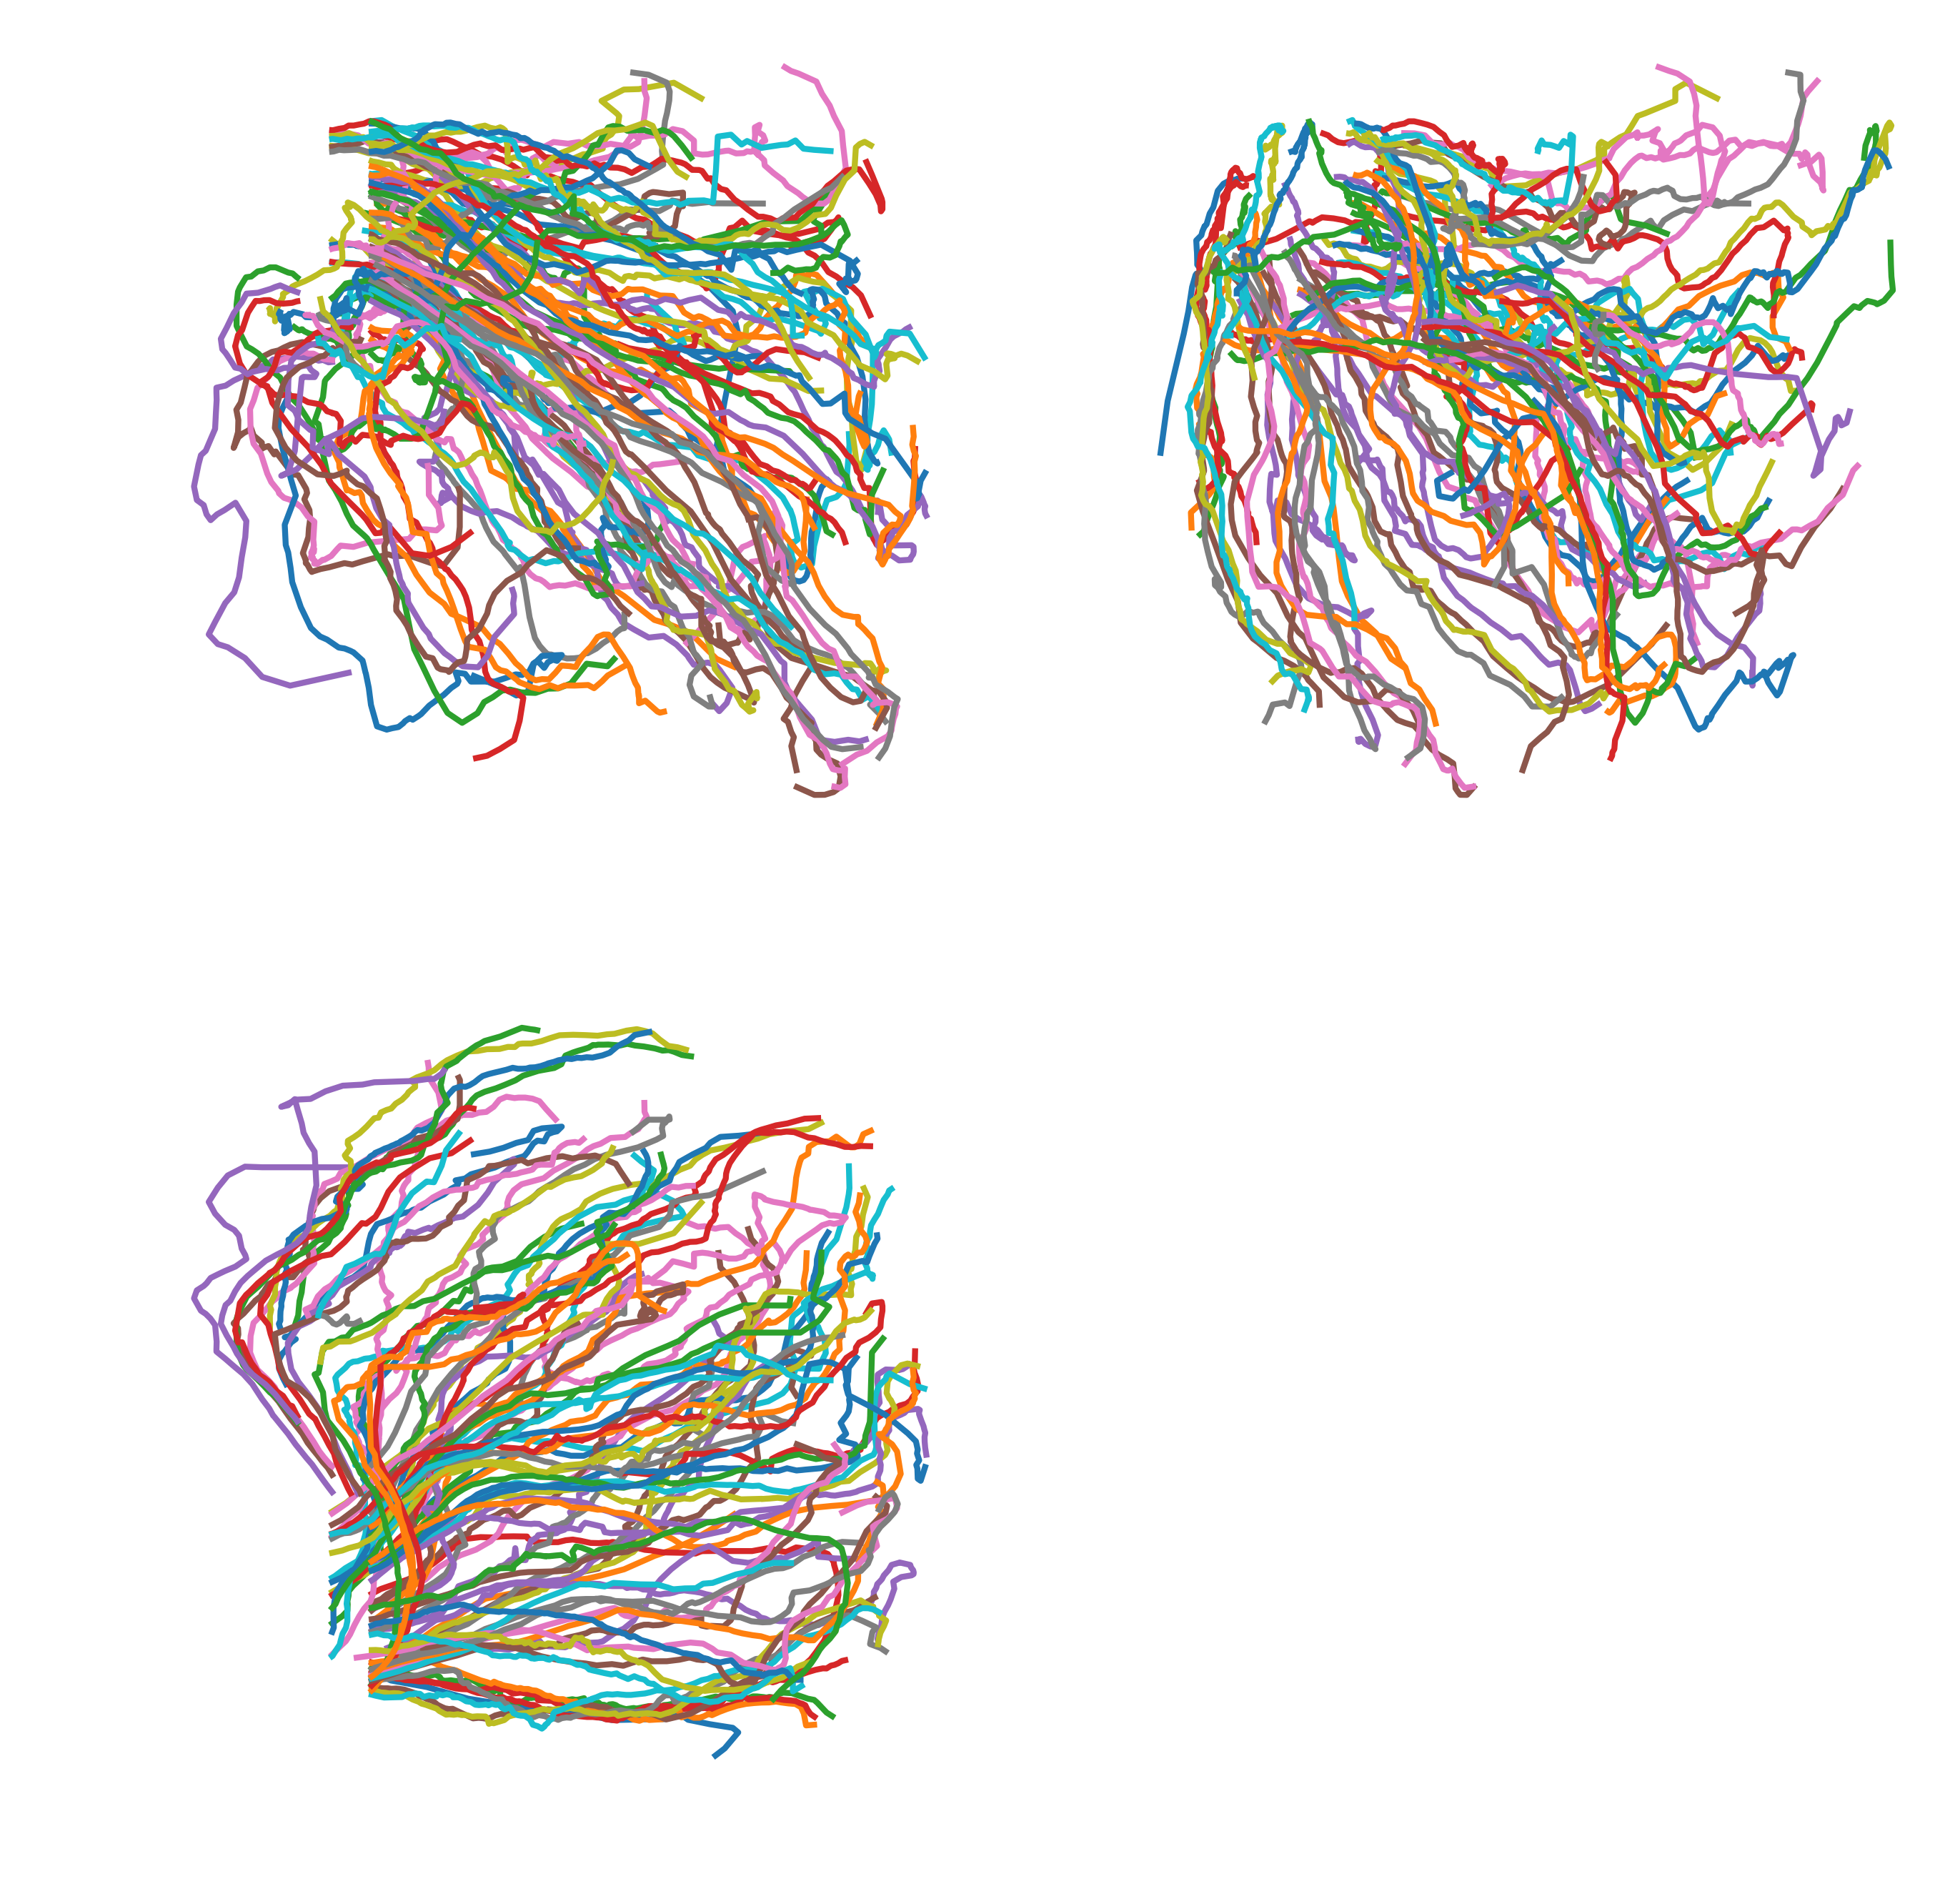

In [23]:
### TESTING ###
# 1. visualize random sample of central segments
fig, ax = plt.subplots(2, 2, figsize=[8, 8])
skel_sample = random.sample(list(central_segs.keys()), 100)

for s, central in central_segs.items():
    if s not in skel_sample:
        continue
    coord_map = {data[0]: data[3:6] for data in C.skel_data[s].skel_nodes}
    x, y, z = np.array([coord_map[n] for n in central]).T

    ax[0,0].plot(x, y)
    ax[0,1].plot(z, y)
    ax[1,0].plot(x, z)
ax[0, 0].axis('off')
ax[0, 1].axis('off')
ax[1, 0].axis('off')
ax[1, 1].remove()

plt.show()

loose end: 13063, A3_L3

277966
omB1_L1


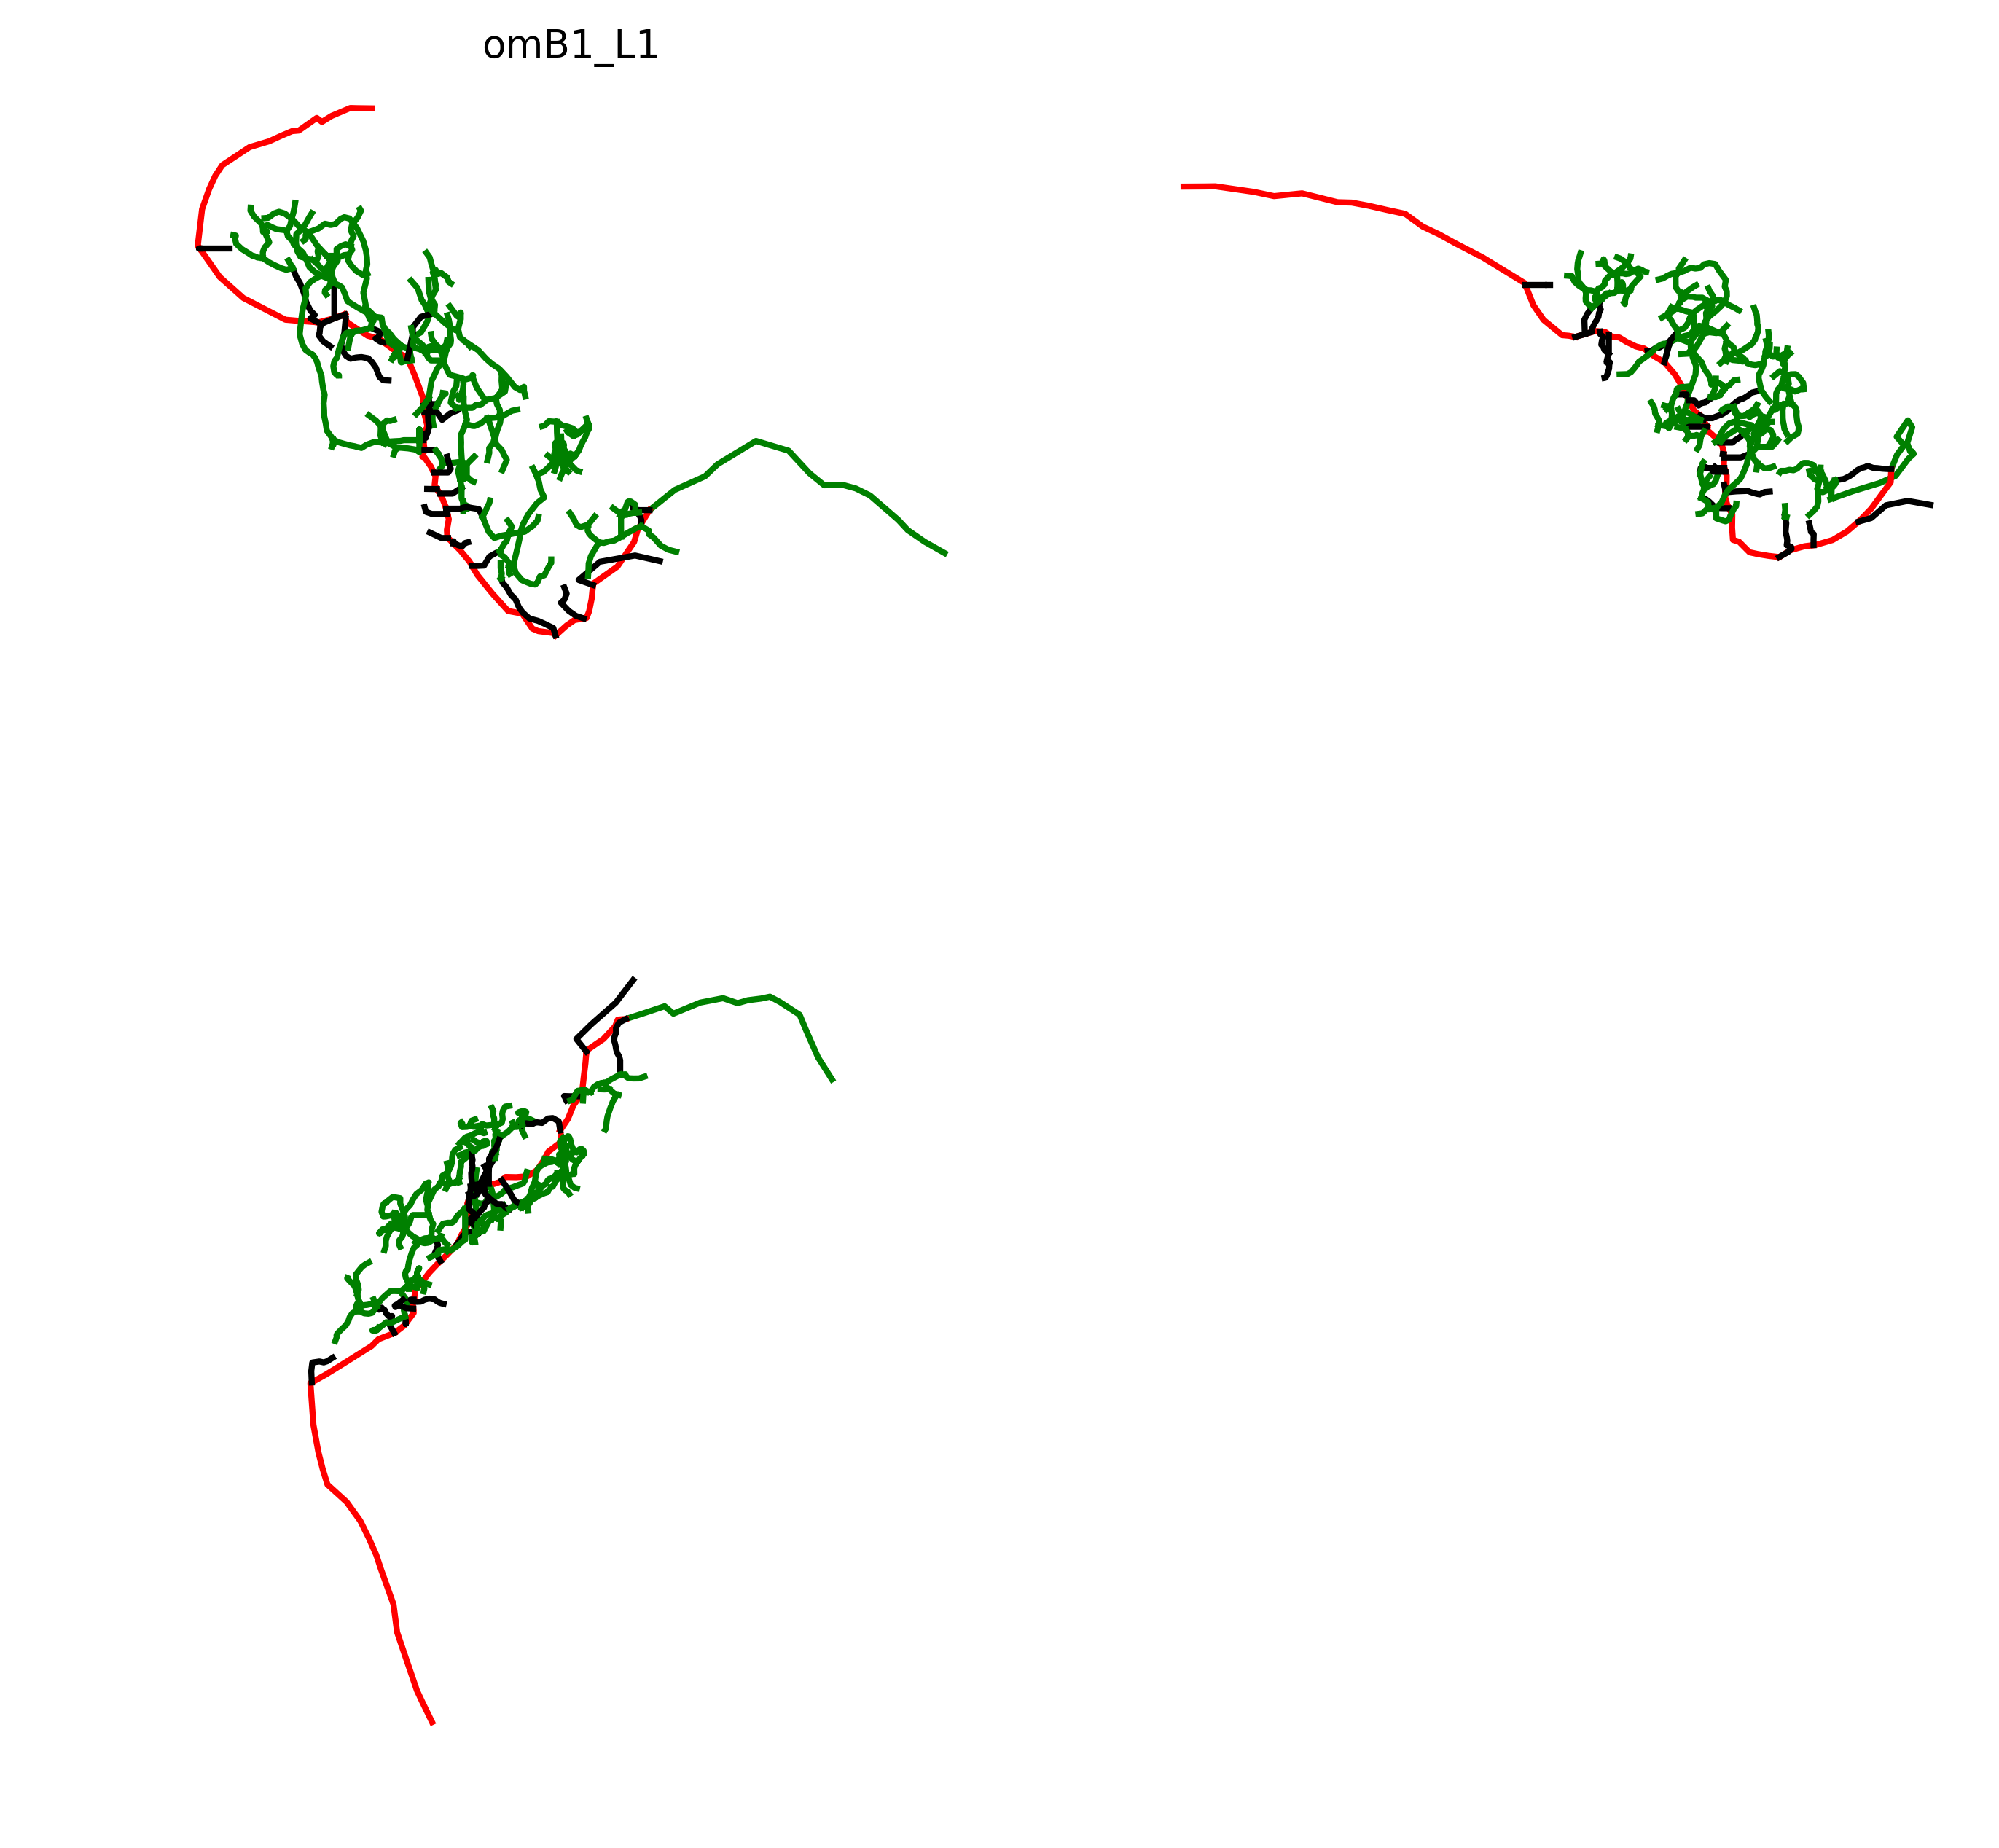

In [42]:
# 2. Visualize a random neurite's central segs vs their branches
fig, ax = plt.subplots(2, 2, figsize=[8, 8])
skel_sample = random.sample(list(central_segs.keys()), 1)

for s, central in central_segs.items():
    #print(central)
    if s not in skel_sample:
        continue
        
    print(s)
    print(C.skel_data[s].name)
    coord_map = {data[0]: data[3:6] for data in C.skel_data[s].skel_nodes}
    for b, seg in segments[s].items():
        #print(b)
        x, y, z = np.array([coord_map[n] for n in seg]).T
        if (int(b) in central):
            ax[0,0].plot(x, y, c='r')
            ax[0,1].plot(z, y, c='r')
            ax[1,0].plot(x, z, c='r')
        elif (int(seg[0]) in central):
            ax[0,0].plot(x, y, c='k')
            ax[0,1].plot(z, y, c='k')
            ax[1,0].plot(x, z, c='k')
        else:
            ax[0,0].plot(x, y, c='g')
            ax[0,1].plot(z, y, c='g')
            ax[1,0].plot(x, z, c='g')
    
ax[0,0].set_title(C.skel_data[skel_sample[0]].name)
ax[0, 0].axis('off')
ax[0, 1].axis('off')
ax[1, 0].axis('off')
ax[1, 1].remove()
ax[0, 0].set_aspect(1)
ax[0, 1].set_aspect(1)
ax[1, 0].set_aspect(1)

plt.show()

Histograms of path length and seg distance

In [33]:
df = pd.DataFrame(summary_data)

In [34]:

length_data = []


for i, data in df.iterrows():
    this_id = data['skel_id']  #str
    arbors = [s for s in segments[this_id].keys() if int(s) not in central_segs[this_id]]
    
    for a in arbors:
        length_data.append({'skel_id': this_id, 
                            'subtype': data['subtype'],
                            'om': data['om'], 
                            'arbor_node': a, 
                            'arbor_length': seg_lengths[this_id][a], 
                            'arbor_distance': seg_distances[this_id][a]})
length_data = pd.DataFrame(length_data)
fig, ax = plt.subplots(2)
st_cm = subtype_cm()

for s, rows in length_data.groupby('subtype'):
    sns.distplot(rows['arbor_length'], ax=ax[0], color=st_cm[s], label='L'+ s[-1])
    sns.distplot(rows['arbor_distance'], ax=ax[1], color=st_cm[s], label='L'+ s[-1])
    
    print(rows['arbor_length'].max())


KeyError: 'skel_id'

In [ ]:

df.head()

In [ ]:

for i, skel_data in df.iterrows():
    
    this_skel = skel_data['skel_id']
    
    if this_skel != '8145':
        continue
    
    this_central = central_segs[this_skel]
    branches = branch_segs[this_skel]
    
    print(this_central)
    print(branches)
    for b, bseg in branches.items():
        print(f"branch {b}, {len(bseg)} nodes, {len(list(set(bseg) & set(this_central)))} in central")
    #df.loc[i, 'arbor_path_length'] = sum([v for k, v in seg_lengths[skel_id].items() if ])

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=[10, 5])

for i, s in enumerate(['n_branch_points', 'n_central_nodes', 'n_total_nodes']):
    x = df.groupby('om')[s].mean()
    y = df.groupby('om')[s].var()
    axes[0, i].scatter(x, y)
    axes[0, i].set_title(s)
    
    x = df.groupby('subtype')[s].mean()
    y = df.groupby('subtype')[s].var()
    axes[1, i].scatter(x, y)
    
plt.show()

In [ ]:
df = pd.DataFrame(results)
df['n_den_nodes'] = df['n_total_nodes'] - df['n_central_nodes']
df['ratio'] = df['n_den_nodes'] / df['n_total_nodes']

In [ ]:
#{b: seg for b, seg in branch_segs['47823'].items() if b not in central_segs['47823'] & seg[-1] not in central_segs['']}
test_skel = '12794'
print(C.skel_data[test_skel].name)

p = path_lengths(branch_segs[test_skel], node_list=C.skel_data[test_skel].skel_nodes)
c = central_segs[test_skel]

In [ ]:
total = sum([v for k, v in p.items()])
branch_total = sum([v for k, v in p.items() if k not in c])
central_total = seg_length(c, C.cfg, {data[0]: data[2:5] for data in C.skel_data[test_skel].skel_nodes})

print(total)
print(total - central_total)
print(branch_total)
print(central_total)

In [ ]:
print(C.skel_data['47823'].name)
some_branch_nodes = list(branch_segs['47823'].keys())
this_center_segment = central_segs['47823']

union = lambda l1, l2 : list(set(l1) & set(l2))

union(some_branch_nodes, this_center_segment)
